### ESS563 Synthetic Seismograms for displacements, strains, and rotations 
#### Yoichiro Dobashi

In [2]:
import os, math, yaml
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
# ---------- utils ----------
def load_config(path="input.yaml"):
    """
    Load YAML configuration and automatically compute:
      - Source time constant tau from corner frequency fc
      - Recommended record length T based on travel times
      - Sampling interval dt satisfying Nyquist criterion
    """
    with open(path, "r") as f:
        cfg = yaml.safe_load(f)

    elastic  = cfg["elastic"]
    source   = cfg["source"]
    stations = cfg["stations"]
    sim      = cfg["simulation"]

    # --- Compute tau from fc (Brune model) ---
    fc = float(source["fc"])
    if fc <= 0:
        raise ValueError("Corner frequency fc must be positive.")
    tau = 1.0 / (2.0 * math.pi * fc)
    source["tau"] = tau

    # --- Compute maximum source–station distance ---
    src = np.array(source["location"], float)
    r_max = 0.0
    for info in stations.values():
        pos = np.array(info["position"], float)
        if len(pos) != 3:
            raise ValueError(f"Station position must have 3 coordinates: got {pos}")
        r = np.linalg.norm(pos - src)
        if r > r_max:
            r_max = r

    alpha = float(elastic["vp"])
    beta  = float(elastic["vs"])

    # --- Recommended record length ---
    # T >= 6 * max(r/alpha, r/beta) + 5 * tau
    if alpha <= 0 or beta <= 0:
        raise ValueError("Elastic velocities must be positive.")
    T_rec = 6.0 * max(r_max / alpha, r_max / beta) + 5.0 * tau

    # --- Recommended sampling interval ---
    # Nyquist f_Nyq = 1 / (2*dt) >= 3*fc → dt <= 1 / (6*fc)
    dt_rec = 1.0 / (6.0 * fc)

    # --- Apply only if user didn't specify manually ---
    if sim.get("duration") in (None, 0):
        sim["duration"] = T_rec
    if sim.get("dt") in (None, 0):
        sim["dt"] = dt_rec

    print("\n===== Auto Configuration Summary =====")
    print(f"fc = {fc:.2f} Hz  →  τ = {tau:.3f} s")
    print(f"r_max = {r_max/1000:.2f} km, α = {alpha:.1f}, β = {beta:.1f}")
    print(f"Recommended record length T = {T_rec:.2f} s")
    print(f"Recommended sampling interval dt = {dt_rec:.4f} s")
    print(f"(f_Nyq = {1/(2*dt_rec):.1f} Hz ≥ 3·fc = {3*fc:.1f} Hz)")
    print("======================================\n")

    return elastic, source, stations, sim


def rad(d):
    """Convert degrees to radians."""
    return np.deg2rad(d)


def delay_interp(sig, t, delay):
    """Return signal s(t - delay) using linear interpolation (zero outside range)."""
    if len(t) == 0 or len(sig) == 0:
        raise ValueError("Input signal or time vector is empty.")
    return np.interp(t - delay, t, sig, left=0.0, right=0.0)


In [4]:
# -----------------------------
# 1) source(): time-domain ṁ(t), analytic d²ṁ/dt²,
#              mechanism builders (strike/dip/rake → M̂, or arbitrary 6-vector)
# -----------------------------
def source(t, src):
    """
    Compute Brune-type moment-rate and its 2nd derivative,
    and construct the seismic moment tensor M̂.

    Parameters
    ----------
    t : array
        Time vector [s]
    src : dict
        Source dictionary with keys:
        - M0 : seismic moment [N·m]
        - tau : rise time constant [s]
        - type : 'double_couple' or 'custom'
        - mechanism : {strike, dip, rake}
        - tensor : {Mxx,Myy,Mzz,Mxy,Mxz,Myz} (optional for custom)

    Returns
    -------
    mdot  : array, moment-rate function ṁ(t)
    mddot : array, 2nd derivative d²ṁ/dt²
    Mhat  : 3×3 numpy array, normalized moment tensor (unit scale)
    """
    # === Brune-type moment rate ===
    # (12)
    M0  = float(src["M0"])
    tau = float(src["tau"])
    mdot = (M0 / tau**2) * t * np.exp(-t / tau)
    mdot[t < 0] = 0.0

    # analytic 2nd derivative of ṁ(t)
    mddot = (M0 / tau**3) * np.exp(-t / tau) * (tau - t)
    mddot[t < 0] = 0.0

    # === Mechanism tensor ===
    def dc_tensor_from_sdr(strike, dip, rake):
        s, d, r = rad(strike), rad(dip), rad(rake)
        # fault normal (n_f) and slip (s_f) in ENU coordinates
        n_f = np.array([
            -np.sin(d) * np.sin(s),
             np.sin(d) * np.cos(s),
            -np.cos(d)
        ])
        s_f = np.array([
             np.cos(r) * np.cos(s) + np.sin(r) * np.cos(d) * np.sin(s),
             np.cos(r) * np.sin(s) - np.sin(r) * np.cos(d) * np.cos(s),
             np.sin(r) * np.sin(d)
        ])
        return np.outer(s_f, n_f) + np.outer(n_f, s_f)  # symmetric DC (unit)

    if src.get("type", "double_couple") == "double_couple":
        mech = src["mechanism"]
        Mhat = dc_tensor_from_sdr(mech["strike"], mech["dip"], mech["rake"])
    else:
        T = src["tensor"]
        Mhat = np.array([
            [T["Mxx"], T["Mxy"], T["Mxz"]],
            [T["Mxy"], T["Myy"], T["Myz"]],
            [T["Mxz"], T["Myz"], T["Mzz"]]
        ], dtype=float)

    return mdot, mddot, Mhat

In [5]:
def greens_td(elastic, r, n, t, mddot):

    alpha, beta = float(elastic["vp"]), float(elastic["vs"])

    # --- Time-delayed sources ---
    mddot_P = delay_interp(mddot, t, r / alpha)
    mddot_S = delay_interp(mddot, t, r / beta)

    # --- Identity and projection operators ---
    I = np.eye(3)
    nnT = np.outer(n, n)

    # --- Tensor–vector maps (for any symmetric A) ---
    def P0(A): return n * (n @ A @ n)
    def S0(A): return (I - nnT) @ (A @ n)
    def P1(A): return 3 * n * (n @ A @ n) - 2 * (A @ n)
    def S1(A): return (I - 3 * nnT) @ (A @ n) + 2 * n * (n @ A @ n)
    def Nterm(A):
        An = A @ n
        An_par = n * (n @ An)
        return 3 * n * (n @ A @ n) - An - An_par

    tensor_maps = {"P0": P0, "S0": S0, "P1": P1, "S1": S1, "N": Nterm}

    return mddot_P, mddot_S, tensor_maps

In [6]:
# -----------------------------
# 3) synth(): assemble u(t) at each station (far-field only)
# -----------------------------
def synth(elastic, source_cfg, stations, t, Mhat, mddot):
    rho   = float(elastic["density"])
    alpha = float(elastic["vp"])
    beta  = float(elastic["vs"])
    src_xyz = np.array(source_cfg["location"], float)

    seismos = {}

    for name, info in stations.items():
        # --- Geometry: source–receiver vector ---
        sta_xyz = np.array(info["position"], float)
        rvec = sta_xyz - src_xyz
        r = np.linalg.norm(rvec)
        n = rvec / r  # unit direction vector

        # --- Green’s function (P0, S0 only) ---
        mddot_P, mddot_S, maps = greens_td(elastic, r, n, t, mddot)

        # --- Radiation pattern vectors (far-field only) ---
        vP = maps["P0"](Mhat)        # n (nᵀ M n)
        vS = maps["S0"](Mhat)        # (I − n nᵀ)(M n)

        # --- Medium and geometric coefficients ---
        coefP = 1.0 / (4.0 * np.pi * rho * alpha**3 * r)
        coefS = 1.0 / (4.0 * np.pi * rho * beta **3 * r)

        # --- Far-field displacement (P + S) ---
        u = (coefP * mddot_P[:, None] * vP[None, :]
           + coefS * mddot_S[:, None] * vS[None, :])

        # --- Store results ---
        seismos[name] = dict(u=u, r=r, n=n, vP=vP, vS=vS)

    return seismos


In [7]:
# -----------------------------
# 4) strain_theory(): analytical far-field strain & rotation
#     ε_ij = 1/2 (∂u_i/∂x_j + ∂u_j/∂x_i)
#     Ω_ij = 1/2 (∂u_i/∂x_j - ∂u_j/∂x_i)
#     Using full far-field derivative of u_P and u_S (Eq. 11)
# -----------------------------
def strain_theory(elastic, source_cfg, stations, t, Mhat, mddot):
    """
    Compute the theoretical far-field strain tensor ε_ij^(th)(t)
    and rotation tensor Ω_ij^(th)(t) from the P/S far-field approximation.

    Parameters
    ----------
    elastic : dict   (ρ, vp, vs)
    source_cfg : dict (location)
    stations : dict  (position per station)
    t : ndarray       time array
    Mhat : ndarray    normalized moment tensor (3×3)
    mddot : ndarray   2nd derivative of moment-rate function

    Returns
    -------
    results : dict{name: {'strain': ε_ij(t), 'rotation': Ω_ij(t), 'omega_vec': ω(t)}}
              ε_ij, Ω_ij : (Nt,3,3)
              ω(t) : (Nt,3)  # rotational vector components
    """

    rho   = float(elastic["density"])
    alpha = float(elastic["vp"])
    beta  = float(elastic["vs"])
    src_xyz = np.array(source_cfg["location"], float)

    # Third derivative of moment-rate: d³m/dt³
    dt = t[1] - t[0]
    mdddot = np.gradient(mddot, dt)

    results = {}

    for name, info in stations.items():
        sta_xyz = np.array(info["position"], float)
        rvec = sta_xyz - src_xyz
        r = np.linalg.norm(rvec)
        n = rvec / r

        # --- Radiation operators (same as synth) ---
        I = np.eye(3)
        P0 = n * (n @ Mhat @ n)                       # n (nᵀ M n)
        S0 = (I - np.outer(n, n)) @ (Mhat @ n)        # (I − n nᵀ)(M n)

        # --- Retarded-time delays ---
        delay_P = r / alpha
        delay_S = r / beta
        m3_P = np.interp(t - delay_P, t, mdddot, left=0.0, right=0.0)
        m3_S = np.interp(t - delay_S, t, mdddot, left=0.0, right=0.0)

        # --- Spatial derivatives ∂u_i/∂x_j ---
        coefP = 1.0 / (4.0 * np.pi * rho * alpha**4 * r)
        coefS = 1.0 / (4.0 * np.pi * rho * beta **4 * r)
        grad_P = -coefP * m3_P[:, None, None] * (np.outer(P0, n))[None, :, :]
        grad_S = -coefS * m3_S[:, None, None] * (np.outer(S0, n))[None, :, :]
        grad = grad_P + grad_S  # (Nt,3,3)

        # --- Strain tensor ε_ij (symmetric) ---
        eps = 0.5 * (grad + np.transpose(grad, (0, 2, 1)))

        # --- Rotation tensor Ω_ij (antisymmetric) ---
        rot = 0.5 * (grad - np.transpose(grad, (0, 2, 1)))

        # --- Rotation vector ω = (Ω_32, Ω_13, Ω_21) ---
        omega = np.stack([rot[:, 2, 1], rot[:, 0, 2], rot[:, 1, 0]], axis=1)

        results[name] = dict(strain=eps, rotation=rot, omega_vec=omega)

    return results


#### strain_fd is including spatial gaussian filter (default is sigma=0.0)

In [9]:
def strain_fd(elastic, source_cfg, stations, t, Mhat, mddot,
              order: int = 2,
              prefilter: dict | None = {"kind": "gaussian", "sigma_cells": 0}):
    """
    Array-derived strain on an x–y grid via centered finite differences.
    Default: apply a spatial Gaussian low-pass (sigma = 1 cell) BEFORE differencing.
    Set prefilter=None to disable smoothing.
    """
    import numpy as np
    # ---- helpers (gaussian smoothing) ----
    def _gaussian_kernel1d(sigma_cells: float):
        R = max(1, int(round(3.0 * float(sigma_cells))))
        x = np.arange(-R, R+1, dtype=float)
        k = np.exp(-(x*x) / (2.0 * sigma_cells * sigma_cells))
        k /= k.sum()
        return k
    def _pad_reflect(arr, pad, axis):
        pad_width = [(0, 0)] * arr.ndim
        pad_width[axis] = (pad, pad)
        return np.pad(arr, pad_width, mode="reflect")
    def _convolve1d_reflect(arr, kernel, axis):
        pad = len(kernel)//2
        ap = _pad_reflect(arr, pad, axis)
        return np.apply_along_axis(lambda a: np.convolve(a, kernel, mode="valid"),
                                   axis, ap)
    def _gaussian_smooth_xy(U_in: np.ndarray, sigma_cells: float) -> np.ndarray:
        k = _gaussian_kernel1d(sigma_cells)
        U = U_in.copy()
        for comp in range(3):
            U[..., comp] = _convolve1d_reflect(U[..., comp], k, axis=2)  # x
            U[..., comp] = _convolve1d_reflect(U[..., comp], k, axis=1)  # y
        return U

    # ---- infer grid (same as前) ----
    recs = []
    for k, info in stations.items():
        x, y, z = map(float, info["position"])
        recs.append((k, x, y, z))
    xs_all = np.unique(np.round([r[1] for r in recs], 6))
    ys_all = np.unique(np.round([r[2] for r in recs], 6))
    nx, ny = len(xs_all), len(ys_all)
    if order not in (2, 4):
        raise ValueError("order must be 2 or 4.")
    minN = 3 if order == 2 else 5
    if nx < minN or ny < minN:
        raise ValueError(f"Need at least a {minN}×{minN} grid for order={order}.")
    grid_keys = [[None]*nx for _ in range(ny)]
    for k, x, y, _ in recs:
        i = int(np.where(xs_all == np.round(x, 6))[0][0])
        j = int(np.where(ys_all == np.round(y, 6))[0][0])
        grid_keys[j][i] = k
    if any(grid_keys[j][i] is None for j in range(ny) for i in range(nx)):
        raise ValueError("Stations do not form a complete rectangular grid.")
    dxs = np.diff(xs_all); dys = np.diff(ys_all)
    if not (np.allclose(dxs, dxs[0]) and np.allclose(dys, dys[0])):
        raise ValueError("Grid must be uniformly spaced in x and y.")
    dx, dy = float(dxs[0]), float(dys[0])

    # ---- synth & pack ----
    se = synth(elastic, source_cfg, stations, t, Mhat, mddot)
    Nt = next(iter(se.values()))["u"].shape[0]
    U = np.zeros((Nt, ny, nx, 3), dtype=float)
    for j in range(ny):
        for i in range(nx):
            U[:, j, i, :] = se[grid_keys[j][i]]["u"]

    # ---- default prefilter (gaussian σ=1 cell) ----
    if prefilter is not None:
        kind = str(prefilter.get("kind", "")).lower()
        if kind == "gaussian":
            sigma_cells = float(prefilter.get("sigma_cells", 1.0))
            if sigma_cells > 0:
                U = _gaussian_smooth_xy(U, sigma_cells)
        elif kind in ("none", "", None):
            pass
        else:
            raise ValueError(f"Unsupported prefilter kind: {prefilter}")

    # ---- differences (2nd or 4th) ----
    if order == 2:
        dudx = (U[:, :, 2:, :] - U[:, :, :-2, :]) / (2.0 * dx)
        dudy = (U[:, 2:, :, :] - U[:, :-2, :, :]) / (2.0 * dy)
        dudx_i = dudx[:, 1:-1, :, :]
        dudy_i = dudy[:, :, 1:-1, :]
        pad = 1
    else:
        dudx = (-U[:, :, 4:, :] + 8*U[:, :, 3:-1, :] - 8*U[:, :, 1:-3, :] + U[:, :, 0:-4, :]) / (12.0 * dx)
        dudy = (-U[:, 4:, :, :] + 8*U[:, 3:-1, :, :] - 8*U[:, 1:-3, :, :] + U[:, 0:-4, :, :]) / (12.0 * dy)
        dudx_i = dudx[:, 2:-2, :, :]
        dudy_i = dudy[:, :, 2:-2, :]
        pad = 2

    Nt_i, ny_i, nx_i, _ = dudx_i.shape

    # ---- tensors ----
    eps_all = np.full((Nt_i, ny_i, nx_i, 3, 3), np.nan)
    rot_all = np.full((Nt_i, ny_i, nx_i, 3, 3), np.nan)
    omg_all = np.full((Nt_i, ny_i, nx_i, 3),    np.nan)
    eps_all[..., 0, 0] = dudx_i[..., 0]
    eps_all[..., 1, 1] = dudy_i[..., 1]
    eps_xy = 0.5 * (dudx_i[..., 1] + dudy_i[..., 0])
    eps_all[..., 0, 1] = eps_xy
    eps_all[..., 1, 0] = eps_xy
    omega_z = 0.5 * (dudx_i[..., 1] - dudy_i[..., 0])
    rot_all[..., 0, 1] =  omega_z
    rot_all[..., 1, 0] = -omega_z
    omg_all[..., 2]    =  omega_z

    # ---- return dict (interior only) ----
    fd = {}
    for j in range(pad, ny - pad):
        for i in range(pad, nx - pad):
            jj, ii = j - pad, i - pad
            key = grid_keys[j][i]
            fd[key] = {
                "strain":    eps_all[:, jj, ii, :, :],
                "rotation":  rot_all[:, jj, ii, :, :],
                "omega_vec": omg_all[:, jj, ii, :]
            }
    return fd

In [10]:
# ======== MAIN ========
# Load configuration (this automatically computes tau if fc is given)
elastic, source_cfg, stations, sim = load_config("input.yaml")

# --- Time vector ---
t = np.arange(0, sim["duration"], sim["dt"])

# --- Source function ---
mdot, mddot, Mhat = source(t, source_cfg)

# --- Synthesize seismograms ---
seismos = synth(elastic, source_cfg, stations, t, Mhat, mddot)



===== Auto Configuration Summary =====
fc = 2.00 Hz  →  τ = 0.080 s
r_max = 14.46 km, α = 6000.0, β = 3464.0
Recommended record length T = 25.44 s
Recommended sampling interval dt = 0.0833 s
(f_Nyq = 6.0 Hz ≥ 3·fc = 6.0 Hz)



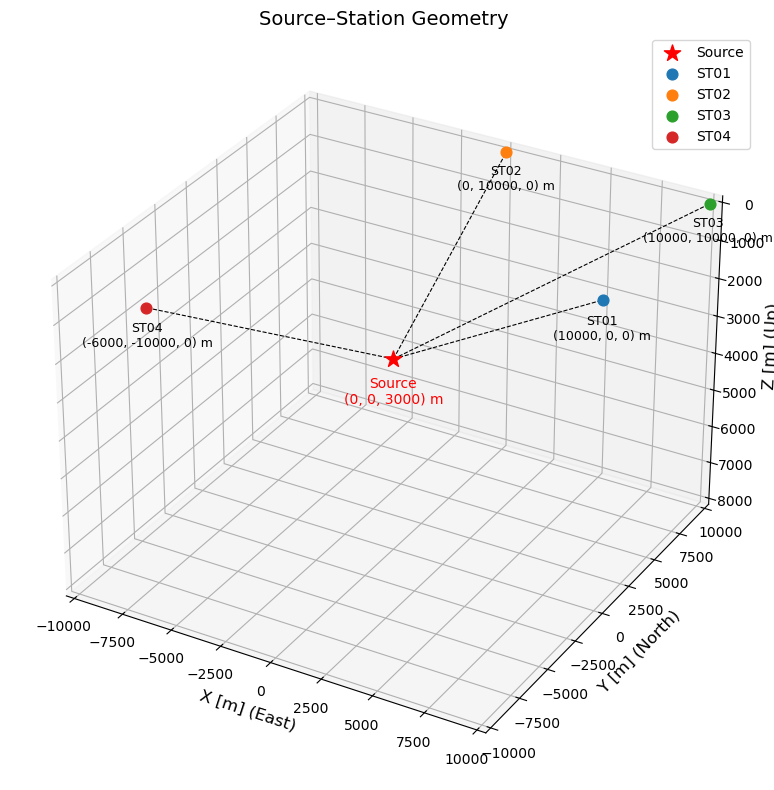

In [11]:
# ======== 3D Source–Station Geometry (with coordinate labels) ========

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# --- Source (red star) ---
src = np.array(source_cfg["location"], float)
ax.scatter(src[0], src[1], src[2], color="red", marker="*", s=150, label="Source")
ax.text(src[0], src[1], src[2] + 1200, 
        f"Source\n({src[0]:.0f}, {src[1]:.0f}, {src[2]:.0f}) m",
        color="red", fontsize=10, ha="center")

# --- Stations (blue circles) ---
for name, info in stations.items():
    pos = np.array(info["position"], float)
    ax.scatter(pos[0], pos[1], pos[2], marker="o", s=60, label=name)
    ax.plot([src[0], pos[0]], [src[1], pos[1]], [src[2], pos[2]], "k--", linewidth=0.8)
    
    ax.text(pos[0], pos[1], pos[2] + 1000,
            f"{name}\n({pos[0]:.0f}, {pos[1]:.0f}, {pos[2]:.0f}) m",
            fontsize=9, ha="center")

# --- Axis labels and style ---
ax.set_xlabel("X [m] (East)", fontsize=12)
ax.set_ylabel("Y [m] (North)", fontsize=12)
ax.set_zlabel("Z [m] (Up)", fontsize=12)
ax.set_title("Source–Station Geometry", fontsize=14)
ax.legend()
ax.grid(True)

# --- Axis range and aspect ratio ---
ax.set_xlim(-10000, 10000)
ax.set_ylim(-10000, 10000)
ax.set_zlim(0, 8000)
ax.invert_zaxis()  # depth increases downward
ax.set_box_aspect([0.8,0.8,0.6])  # uniform scale

plt.tight_layout()
plt.show()


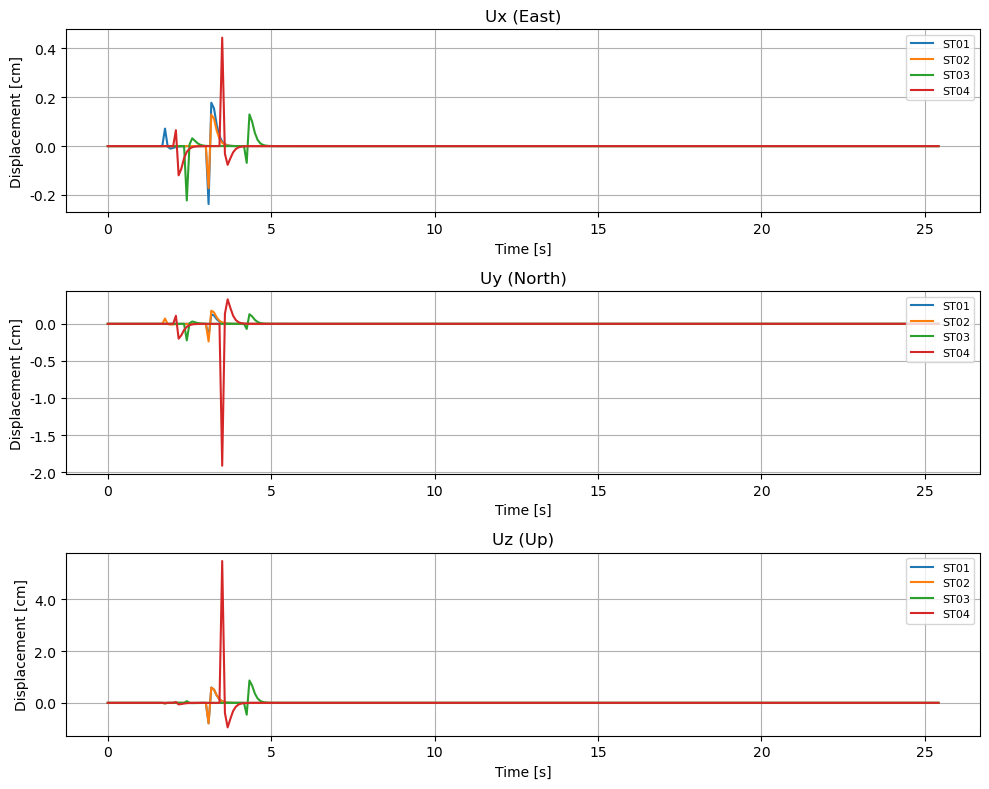

In [12]:
from matplotlib.ticker import FuncFormatter

# ======== Visual (Component-wise, in cm) ========
components = ["Ux (East)", "Uy (North)", "Uz (Up)"]

def cm_fmt(x, _):
    return f"{x:.1f}"

plt.figure(figsize=(10, 8))

for comp in range(3):  # 0:x, 1:y, 2:z
    ax = plt.subplot(3, 1, comp + 1)
    for name, data in seismos.items():
        u = data["u"][:, comp] * 100.0   # <-- convert m -> cm
        plt.plot(t, u, label=f"{name}")
    plt.title(components[comp])
    plt.xlabel("Time [s]")
    plt.ylabel("Displacement [cm]")      # <-- label in cm
    ax.yaxis.set_major_formatter(FuncFormatter(cm_fmt))
    plt.legend(loc="upper right", fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()


Visualizing theoretical strain & rotation at ST04


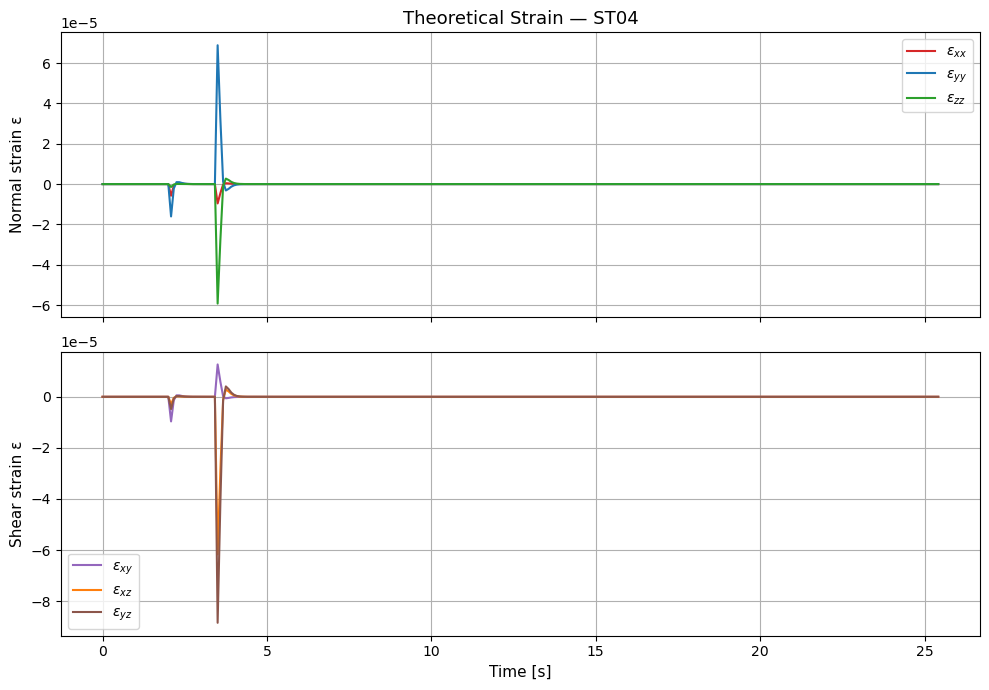

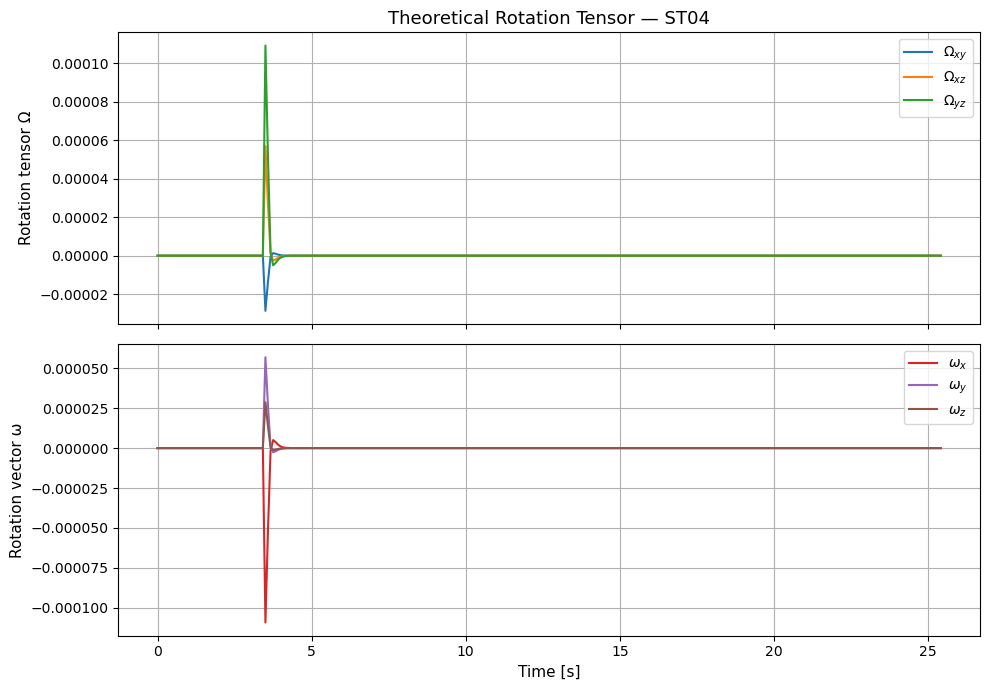

In [13]:
# === Compute theoretical strain & rotation ===
results_theory = strain_theory(elastic, source_cfg, stations, t, Mhat, mddot)

# === Select one station to visualize ===
station_key = list(results_theory.keys())[3]  # e.g., "ST01"
eps   = results_theory[station_key]["strain"]      # (Nt, 3, 3)
rot   = results_theory[station_key]["rotation"]    # (Nt, 3, 3)
omega = results_theory[station_key]["omega_vec"]   # (Nt, 3)

print(f"Visualizing theoretical strain & rotation at {station_key}")

# ==========================================================
# 1️⃣ STRAIN time series (εxx, εyy, εzz, εxy, εxz, εyz)
# ==========================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# --- Normal strain components ---
axes[0].plot(t, eps[:, 0, 0], label=r'$\varepsilon_{xx}$', color='tab:red')
axes[0].plot(t, eps[:, 1, 1], label=r'$\varepsilon_{yy}$', color='tab:blue')
axes[0].plot(t, eps[:, 2, 2], label=r'$\varepsilon_{zz}$', color='tab:green')
axes[0].set_ylabel("Normal strain ε", fontsize=11)
axes[0].set_title(f"Theoretical Strain — {station_key}", fontsize=13)
axes[0].legend()
axes[0].grid(True)

# --- Shear strain components ---
axes[1].plot(t, eps[:, 0, 1], label=r'$\varepsilon_{xy}$', color='tab:purple')
axes[1].plot(t, eps[:, 0, 2], label=r'$\varepsilon_{xz}$', color='tab:orange')
axes[1].plot(t, eps[:, 1, 2], label=r'$\varepsilon_{yz}$', color='tab:brown')
axes[1].set_xlabel("Time [s]", fontsize=11)
axes[1].set_ylabel("Shear strain ε", fontsize=11)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ==========================================================
# 2️⃣ ROTATION tensor Ω_ij and rotation vector ω
# ==========================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# --- Antisymmetric tensor components Ω_ij ---
axes[0].plot(t, rot[:, 0, 1], label=r'$\Omega_{xy}$', color='tab:blue')
axes[0].plot(t, rot[:, 0, 2], label=r'$\Omega_{xz}$', color='tab:orange')
axes[0].plot(t, rot[:, 1, 2], label=r'$\Omega_{yz}$', color='tab:green')
axes[0].set_ylabel("Rotation tensor Ω", fontsize=11)
axes[0].set_title(f"Theoretical Rotation Tensor — {station_key}", fontsize=13)
axes[0].legend()
axes[0].grid(True)

# --- Rotation vector ω = (Ω_32, Ω_13, Ω_21) ---
axes[1].plot(t, omega[:, 0], label=r'$\omega_x$', color='tab:red')
axes[1].plot(t, omega[:, 1], label=r'$\omega_y$', color='tab:purple')
axes[1].plot(t, omega[:, 2], label=r'$\omega_z$', color='tab:brown')
axes[1].set_xlabel("Time [s]", fontsize=11)
axes[1].set_ylabel("Rotation vector ω", fontsize=11)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [14]:
# --- S wavelength from Brune peak ---
fc = float(source_cfg["fc"])
fpeak = 1.3 * fc
beta  = float(elastic["vs"])
lambda_S = beta / fpeak

print(f"f_peak = {fpeak:.3f} Hz,  λ_S = {lambda_S:.1f} m")

# --- Geometry parameters ---
deltas = [0.25, 0.5, 1.0, 2.0, 4.0]    # grid spacing Δ in units of λ_S
apert_multipliers = [4, 8, 12, 16]         # aperture A in units of λ_S

# --- Container for results ---
results_E = {}  # results_E[(A_mult, Δ_mult)] = dict(grid=(xs,ys), seismos=..., strains=...)

# --- Time vector ---
t = np.arange(0, sim["duration"], sim["dt"])

# --- Source time functions ---
mdot, mddot, Mhat = source(t, source_cfg)

# --- Source coordinates ---
src_xy = np.array(source_cfg["location"][:2], float)
src_z  = float(source_cfg["location"][2])

# ===========================================================
# ==========  MAIN LOOP OVER GEOMETRY CONFIGS  ===============
# ===========================================================
for A_mult in apert_multipliers:
    A = A_mult * lambda_S       # aperture side length [m]
    half = 0.5 * A

    for Δ_mult in deltas:
        Δ = Δ_mult * lambda_S   # station spacing [m]

        # Number of grid points (odd number to center array on source)
        nx = int(round(A / Δ)) + 1
        if nx % 2 == 0:
            nx += 1
        ny = nx

        xs = np.linspace(-half, half, nx) + src_xy[0]
        ys = np.linspace(-half, half, ny) + src_xy[1]

        # --- Define stations on the surface (z=0) ---
        stations_grid = {}
        k = 0
        for j, y in enumerate(ys):
            for i, x in enumerate(xs):
                k += 1
                stations_grid[f"G{A_mult}_{Δ_mult}_{k:04d}"] = {
                    "position": [float(x), float(y), 0.0]
                }

        # --- Compute synthetic displacements (P+S far-field) ---
        seismos_grid = synth(elastic, source_cfg, stations_grid, t, Mhat, mddot)

        # --- Compute analytical strain & rotation (theoretical) ---
        strains_grid = strain_theory(elastic, source_cfg, stations_grid, t, Mhat, mddot)
        # --- Save results ---
        results_E[(A_mult, Δ_mult)] = dict(
            grid=(xs, ys),
            seismos=seismos_grid,
            strains=strains_grid
        )

        print(f"✅ Done: A={A_mult} λS ({A:,.0f} m),  Δ={Δ_mult} λS ({Δ:,.0f} m),  N={nx*ny} stations")

f_peak = 2.600 Hz,  λ_S = 1332.3 m
✅ Done: A=4 λS (5,329 m),  Δ=0.25 λS (333 m),  N=289 stations
✅ Done: A=4 λS (5,329 m),  Δ=0.5 λS (666 m),  N=81 stations
✅ Done: A=4 λS (5,329 m),  Δ=1.0 λS (1,332 m),  N=25 stations
✅ Done: A=4 λS (5,329 m),  Δ=2.0 λS (2,665 m),  N=9 stations
✅ Done: A=4 λS (5,329 m),  Δ=4.0 λS (5,329 m),  N=9 stations
✅ Done: A=8 λS (10,658 m),  Δ=0.25 λS (333 m),  N=1089 stations
✅ Done: A=8 λS (10,658 m),  Δ=0.5 λS (666 m),  N=289 stations
✅ Done: A=8 λS (10,658 m),  Δ=1.0 λS (1,332 m),  N=81 stations
✅ Done: A=8 λS (10,658 m),  Δ=2.0 λS (2,665 m),  N=25 stations
✅ Done: A=8 λS (10,658 m),  Δ=4.0 λS (5,329 m),  N=9 stations
✅ Done: A=12 λS (15,988 m),  Δ=0.25 λS (333 m),  N=2401 stations
✅ Done: A=12 λS (15,988 m),  Δ=0.5 λS (666 m),  N=625 stations
✅ Done: A=12 λS (15,988 m),  Δ=1.0 λS (1,332 m),  N=169 stations
✅ Done: A=12 λS (15,988 m),  Δ=2.0 λS (2,665 m),  N=49 stations
✅ Done: A=12 λS (15,988 m),  Δ=4.0 λS (5,329 m),  N=25 stations
✅ Done: A=16 λS (21,317 

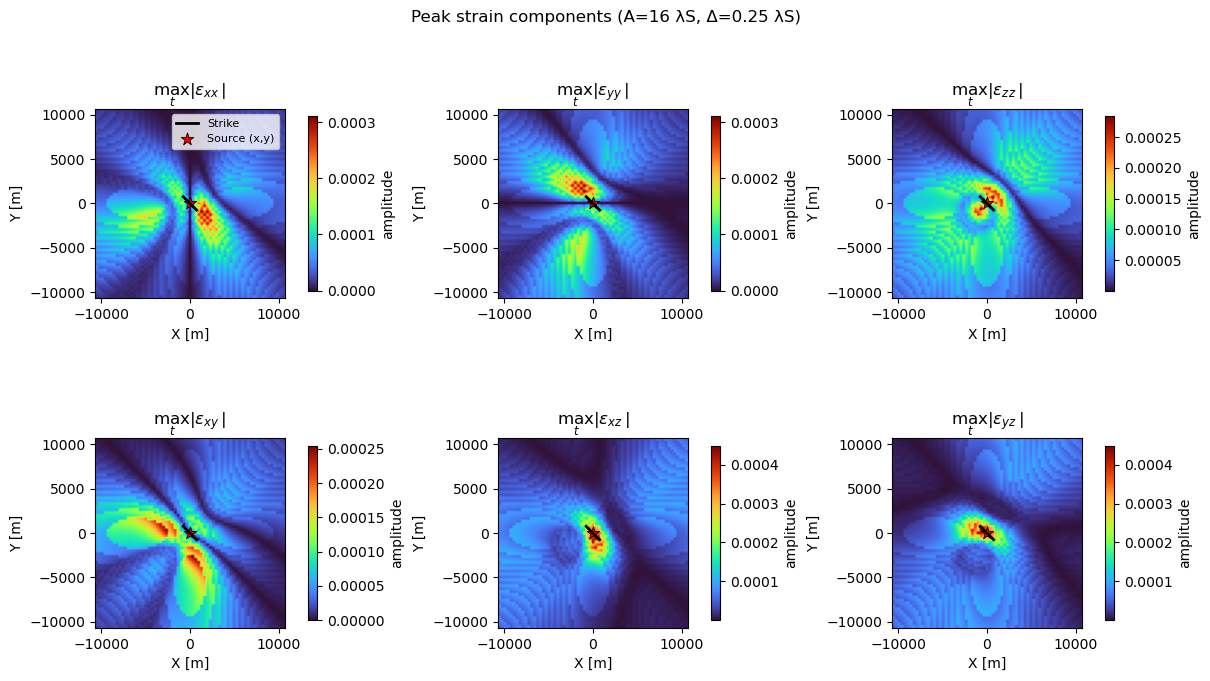

In [15]:
# ===== Full script: 2×3 heatmaps of max |ε_ij(t)| + source & strike markers =====
# --- pull grid & strains for the chosen geometry ---
A_pick, Δ_pick = 16, 0.25  # A=8λS, Δ=1λS など
xs, ys = results_E[(A_pick, Δ_pick)]["grid"]
strains_grid = results_E[(A_pick, Δ_pick)]["strains"]
nx, ny = len(xs), len(ys)

# --- components to visualize (tensor shear as-is; NOT engineering shear) ---
components = ["xx", "yy", "zz", "xy", "xz", "yz"]
ij_map = {"xx": (0, 0), "yy": (1, 1), "zz": (2, 2),
          "xy": (0, 1), "xz": (0, 2), "yz": (1, 2)}

# --- robust key prefix detection (e.g., "G16_0.1_") ---
some_key = next(iter(strains_grid.keys()))
base = some_key.rsplit("_", 1)[0] + "_"

# --- build maps of peak |ε_ij(t)| ---
maps = {c: np.zeros((ny, nx)) for c in components}
idx = 0
for j in range(ny):
    for i in range(nx):
        idx += 1
        key = f"{base}{idx:04d}"
        eps = strains_grid[key]["strain"]  # shape: (Nt,3,3)
        for c in components:
            ii, jj = ij_map[c]
            comp_t = eps[:, ii, jj]
            maps[c][j, i] = np.max(np.abs(comp_t))

# --- source & strike info (projected to X–Y) ---
sx, sy, sz = map(float, source_cfg["location"])
mech = source_cfg["mechanism"]
strike_deg = float(mech["strike"])
dip_deg    = float(mech["dip"])
rake_deg   = float(mech["rake"])

# strike is measured from North clockwise → (E, N) = (sinθ, cosθ)
theta = np.deg2rad(strike_deg)
t_hat = np.array([np.sin(theta), np.cos(theta)])

# pick a short strike line centered at the source
span = max(xs[-1] - xs[0], ys[-1] - ys[0])
L = 0.10 * span
sx0, sy0 = sx - 0.5 * L * t_hat[0], sy - 0.5 * L * t_hat[1]
sx1, sy1 = sx + 0.5 * L * t_hat[0], sy + 0.5 * L * t_hat[1]

# --- titles for panels ---
titles = {
    "xx": r"$\max_t|\varepsilon_{xx}|$",
    "yy": r"$\max_t|\varepsilon_{yy}|$",
    "zz": r"$\max_t|\varepsilon_{zz}|$",
    "xy": r"$\max_t|\varepsilon_{xy}|$",
    "xz": r"$\max_t|\varepsilon_{xz}|$",
    "yz": r"$\max_t|\varepsilon_{yz}|$",
}

# --- plot 2×3 grid ---
fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

for k, (ax, c) in enumerate(zip(axes.ravel(), components)):
    im = ax.imshow(
        maps[c],
        origin="lower",
        extent=[xs[0], xs[-1], ys[0], ys[-1]],
        aspect="equal",
        cmap="turbo"
    )

    # strike short line
    ax.plot([sx0, sx1], [sy0, sy1], "k-", lw=2, label="Strike")
        # source star
    ax.scatter(sx, sy, marker="*", s=90, color="red",
               edgecolors="k", linewidths=0.6, label="Source (x,y)")

    ax.set_title(titles[c])
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.set_ylabel("amplitude")

    if k == 0:
        ax.legend(loc="upper right", fontsize=8)

fig.suptitle(
    f"Peak strain components (A={A_pick} λS, Δ={Δ_pick} λS)\n"
    #f"Strike={strike_deg:.1f}°, Dip={dip_deg:.1f}°, Rake={rake_deg:.1f}°; "
    #f"Source=({sx:.0f}, {sy:.0f}, z={sz:.0f} m)",
    #y=1.02, fontsize=12
)
plt.show()


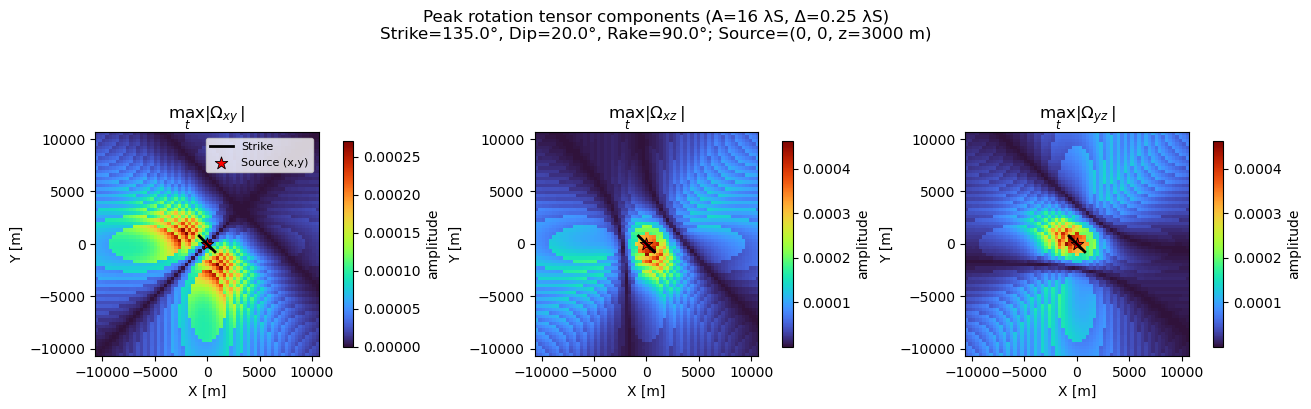

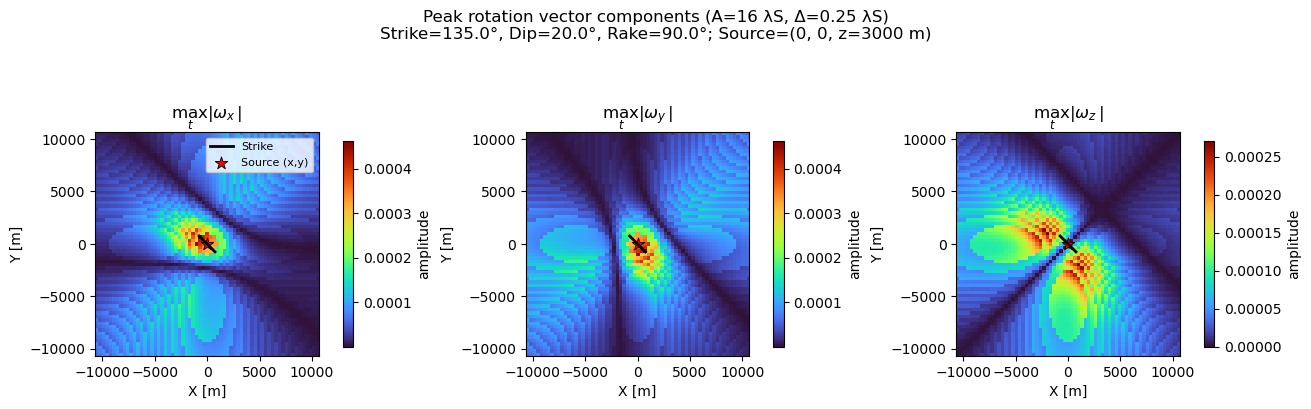

In [16]:
# ===== Rotation: build peak maps for Ω_ij and ω =====
# robust key prefix (reuse the same strategy as strain plots)
some_key = next(iter(strains_grid.keys()))
base = some_key.rsplit("_", 1)[0] + "_"

nx, ny = len(xs), len(ys)

# --- rotation tensor components (Ω_xy, Ω_xz, Ω_yz) ---
rot_comps = ["xy", "xz", "yz"]
ij_map_rot = {"xy": (0, 1), "xz": (0, 2), "yz": (1, 2)}
rot_maps = {c: np.zeros((ny, nx)) for c in rot_comps}

idx = 0
for j in range(ny):
    for i in range(nx):
        idx += 1
        key = f"{base}{idx:04d}"
        rot = strains_grid[key]["rotation"]   # shape: (Nt,3,3)
        for c in rot_comps:
            ii, jj = ij_map_rot[c]
            rot_maps[c][j, i] = np.max(np.abs(rot[:, ii, jj]))

# --- rotation vector components (ωx, ωy, ωz) ---
omega_maps = {k: np.zeros((ny, nx)) for k in ["wx", "wy", "wz"]}

idx = 0
for j in range(ny):
    for i in range(nx):
        idx += 1
        key = f"{base}{idx:04d}"
        rot = strains_grid[key]["rotation"]   # (Nt,3,3)
        # ω = (Ω_32, Ω_13, Ω_21)
        wx_t = rot[:, 2, 1]
        wy_t = rot[:, 0, 2]
        wz_t = rot[:, 1, 0]
        omega_maps["wx"][j, i] = np.max(np.abs(wx_t))
        omega_maps["wy"][j, i] = np.max(np.abs(wy_t))
        omega_maps["wz"][j, i] = np.max(np.abs(wz_t))

# --- source & strike overlay (same as strain plot) ---
sx, sy, sz = map(float, source_cfg["location"])
mech = source_cfg["mechanism"]
strike_deg = float(mech["strike"])
dip_deg    = float(mech["dip"])
rake_deg   = float(mech["rake"])

theta = np.deg2rad(strike_deg)
# strike: from North clockwise → (E,N) = (sinθ, cosθ)
t_hat = np.array([np.sin(theta), np.cos(theta)])
span = max(xs[-1]-xs[0], ys[-1]-ys[0])
L = 0.10 * span
sx0, sy0 = sx - 0.5*L*t_hat[0], sy - 0.5*L*t_hat[1]
sx1, sy1 = sx + 0.5*L*t_hat[0], sy + 0.5*L*t_hat[1]

# ===== Figure A: Ω_ij =====
titles_rot = {
    "xy": r"$\max_t|\Omega_{xy}|$",
    "xz": r"$\max_t|\Omega_{xz}|$",
    "yz": r"$\max_t|\Omega_{yz}|$",
}
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), constrained_layout=True)
for ax, comp in zip(axes.ravel(), rot_comps):
    im = ax.imshow(rot_maps[comp], origin="lower",
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   aspect="equal", cmap="turbo")
    ax.plot([sx0, sx1], [sy0, sy1], "k-", lw=2, label="Strike")
    ax.scatter(sx, sy, marker="*", s=90, color="red",
               edgecolors="k", linewidths=0.6, label="Source (x,y)")
    ax.set_title(titles_rot[comp])
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.set_ylabel("amplitude")
axes[0].legend(loc="upper right", fontsize=8)
fig.suptitle(
    f"Peak rotation tensor components (A={A_pick} λS, Δ={Δ_pick} λS)\n"
    f"Strike={strike_deg:.1f}°, Dip={dip_deg:.1f}°, Rake={rake_deg:.1f}°; "
    f"Source=({sx:.0f}, {sy:.0f}, z={sz:.0f} m)",
    y=1.02, fontsize=12
)
plt.show()

# ===== Figure B: ω components =====
titles_omega = {
    "wx": r"$\max_t|\omega_x|$",
    "wy": r"$\max_t|\omega_y|$",
    "wz": r"$\max_t|\omega_z|$",
}
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), constrained_layout=True)
for ax, key in zip(axes.ravel(), ["wx", "wy", "wz"]):
    im = ax.imshow(omega_maps[key], origin="lower",
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   aspect="equal", cmap="turbo")
    ax.plot([sx0, sx1], [sy0, sy1], "k-", lw=2, label="Strike")
    ax.scatter(sx, sy, marker="*", s=90, color="red",
               edgecolors="k", linewidths=0.6, label="Source (x,y)")
    ax.set_title(titles_omega[key])
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.set_ylabel("amplitude")
axes[0].legend(loc="upper right", fontsize=8)
fig.suptitle(
    f"Peak rotation vector components (A={A_pick} λS, Δ={Δ_pick} λS)\n"
    f"Strike={strike_deg:.1f}°, Dip={dip_deg:.1f}°, Rake={rake_deg:.1f}°; "
    f"Source=({sx:.0f}, {sy:.0f}, z={sz:.0f} m)",
    y=1.02, fontsize=12
)
plt.show()


### TH vs FD

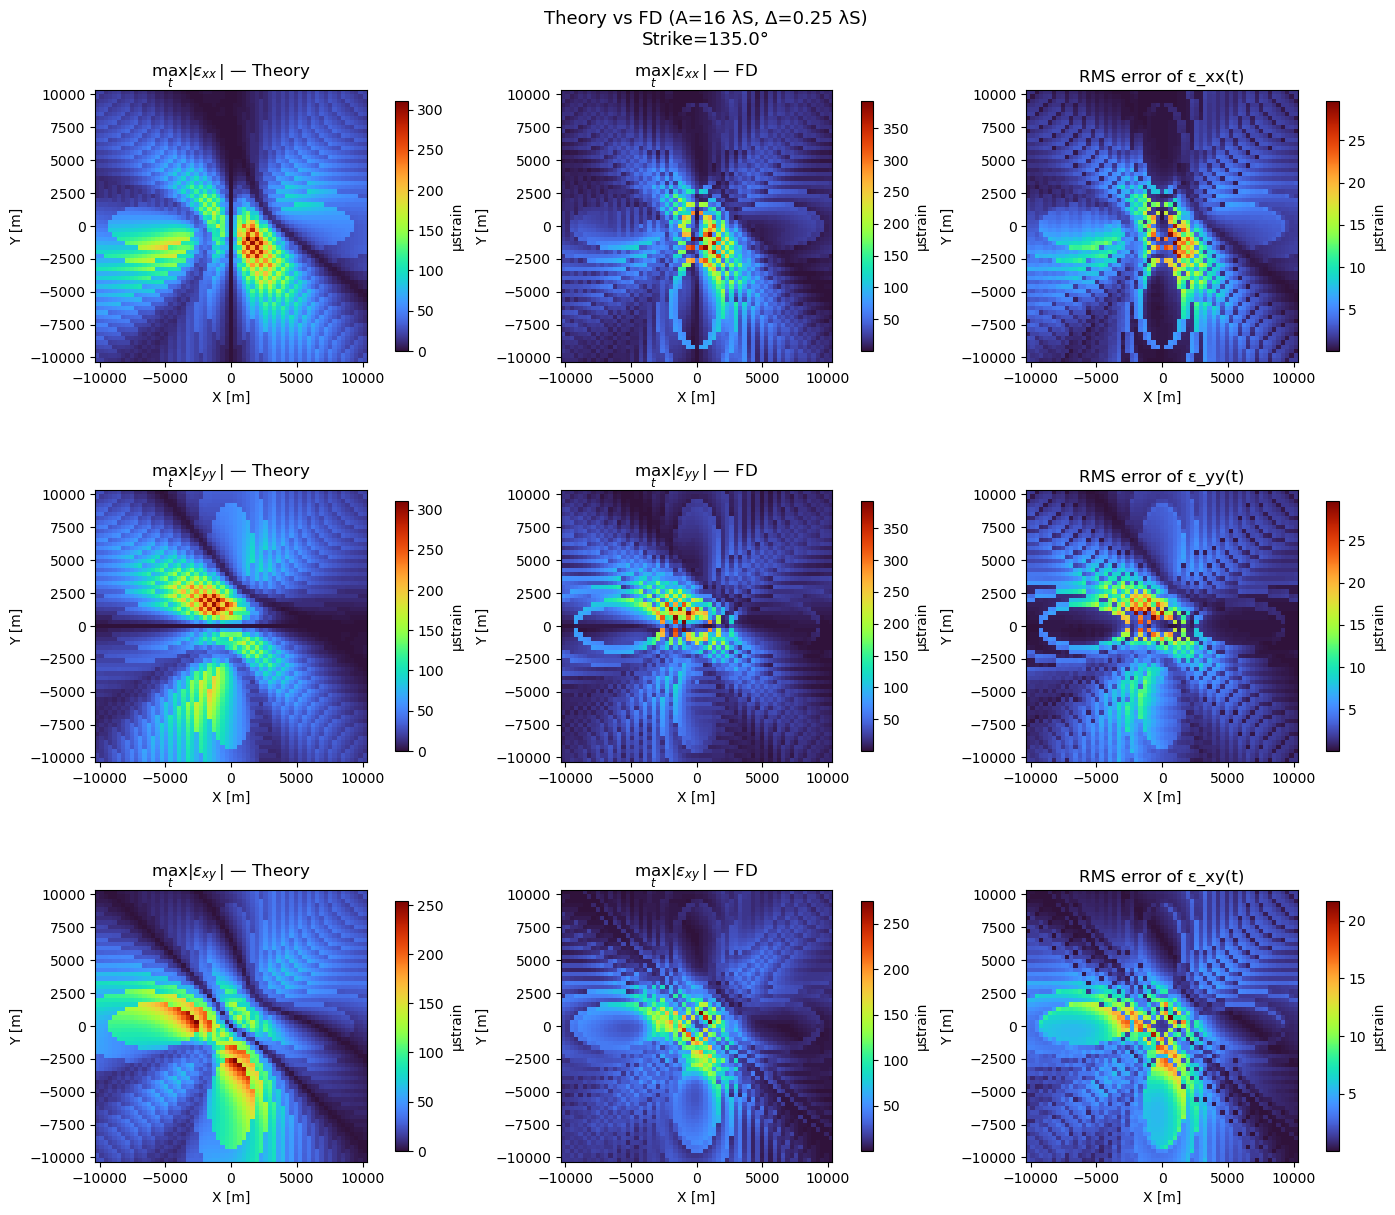

In [18]:
# ---- 1) choose a configuration to plot ----
A_sel =  16    # e.g., pick from your aperture_multipliers
D_sel = 0.25    # e.g., pick from your deltas

if (A_sel, D_sel) not in results_E:
    raise KeyError(f"Config (A={A_sel}, Δ={D_sel}) not found in results_E")

xs, ys = results_E[(A_sel, D_sel)]["grid"]    # tuple (xs, ys)
nx, ny = len(xs), len(ys)
assert nx >= 3 and ny >= 3, "Need at least a 3×3 grid."

# ---- 2) rebuild the exact stations_grid used in the loop (same keys & positions) ----
stations_grid = {}
k = 0
for j, y in enumerate(ys):
    for i, x in enumerate(xs):
        k += 1
        stations_grid[f"G{A_sel}_{D_sel}_{k:04d}"] = {"position": [float(x), float(y), 0.0]}

# ---- 3) get theory strain (reuse if you like) & compute FD strain on this grid ----
# reuse theory from results_E if you want to avoid recomputation
strains_th = results_E[(A_sel, D_sel)]["strains"]  # already theory on the same grid
# if you prefer to recompute: strains_th = strain_theory(elastic, source_cfg, stations_grid, t, Mhat, mddot)

strains_fd = strain_fd(elastic, source_cfg, stations_grid, t, Mhat, mddot)  # interior keys only

# ---- 4) build interior (j,i)->key map aligned to xs/ys ----
grid_keys = [[None]*nx for _ in range(ny)]
k = 0
for j, y in enumerate(ys):
    for i, x in enumerate(xs):
        k += 1
        grid_keys[j][i] = f"G{A_sel}_{D_sel}_{k:04d}"

# interior extent for imshow
extent_i = [xs[1], xs[-2], ys[1], ys[-2]]

# ---- 5) assemble peak and RMS maps (µstrain) ----
SCALE = 1e6
UNIT  = "µstrain"
components = [("xx", (0,0)), ("yy", (1,1)), ("xy", (0,1))]

nx_i, ny_i = nx-2, ny-2
peak_th_maps = {nm: np.full((ny_i, nx_i), np.nan) for nm,_ in components}
peak_fd_maps = {nm: np.full((ny_i, nx_i), np.nan) for nm,_ in components}
rms_maps     = {nm: np.full((ny_i, nx_i), np.nan) for nm,_ in components}

for cname, (ii, jj) in components:
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            key = grid_keys[j][i]
            # FDは interior のみキーがある。なければ skip
            if key not in strains_fd: 
                continue
            eps_th_t = strains_th[key]["strain"][:, ii, jj]
            eps_fd_t = strains_fd[key]["strain"][:, ii, jj]
            th = np.abs(eps_th_t) * SCALE
            fd = np.abs(eps_fd_t) * SCALE
            diff = (eps_fd_t - eps_th_t) * SCALE

            jj_i, ii_i = j-1, i-1
            peak_th_maps[cname][jj_i, ii_i] = np.nanmax(th)
            peak_fd_maps[cname][jj_i, ii_i] = np.nanmax(fd)
            rms_maps[cname][jj_i, ii_i]     = np.sqrt(np.nanmean(diff*diff))

# ---- 6) plot 3×3 (Theory, FD, RMS) ----
titles_row = {
    "xx": r"$\max_t|\varepsilon_{xx}|$",
    "yy": r"$\max_t|\varepsilon_{yy}|$",
    "xy": r"$\max_t|\varepsilon_{xy}|$",
}

fig, axes = plt.subplots(3, 3, figsize=(14, 12), constrained_layout=True)

for r, (cname, _) in enumerate(components):
    th_map = peak_th_maps[cname]
    fd_map = peak_fd_maps[cname]
    rms_map = rms_maps[cname]

    finite = th_map[np.isfinite(th_map)]
    if finite.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        vmin, vmax = float(finite.min()), float(finite.max())
        if not np.isfinite(vmin): vmin = 0.0
        if not np.isfinite(vmax) or vmax <= vmin: vmax = vmin + 1e-12

    # Theory
    ax = axes[r, 0]
    im1 = ax.imshow(th_map, origin='lower', extent=extent_i, aspect='equal',
                    cmap='turbo', vmin=vmin, vmax=vmax)
    ax.set_title(f"{titles_row[cname]} — Theory")
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]")
    cb1 = plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04); cb1.set_label(UNIT)

    # FD
    ax = axes[r, 1]
    im2 = ax.imshow(fd_map, origin='lower', extent=extent_i, aspect='equal',
                    cmap='turbo')
                        #cmap='turbo', vmin=vmin, vmax=vmax)

    ax.set_title(f"{titles_row[cname]} — FD")
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]")
    cb2 = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04); cb2.set_label(UNIT)

    # RMS (independent scale)
    ax = axes[r, 2]
    im3 = ax.imshow(rms_map, origin='lower', extent=extent_i, aspect='equal',
                    cmap='turbo')
    ax.set_title(f"RMS error of ε_{cname}(t)")
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]")
    cb3 = plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04); cb3.set_label(UNIT)

# title
title_lines = [f"Theory vs FD (A={A_sel} λS, Δ={D_sel} λS)"]
try:
    strike = float(source_cfg['mechanism']['strike'])
    title_lines.append(f"Strike={strike:.1f}°")
except Exception:
    pass
fig.suptitle("\n".join(title_lines), y=1.02, fontsize=13)
plt.show()


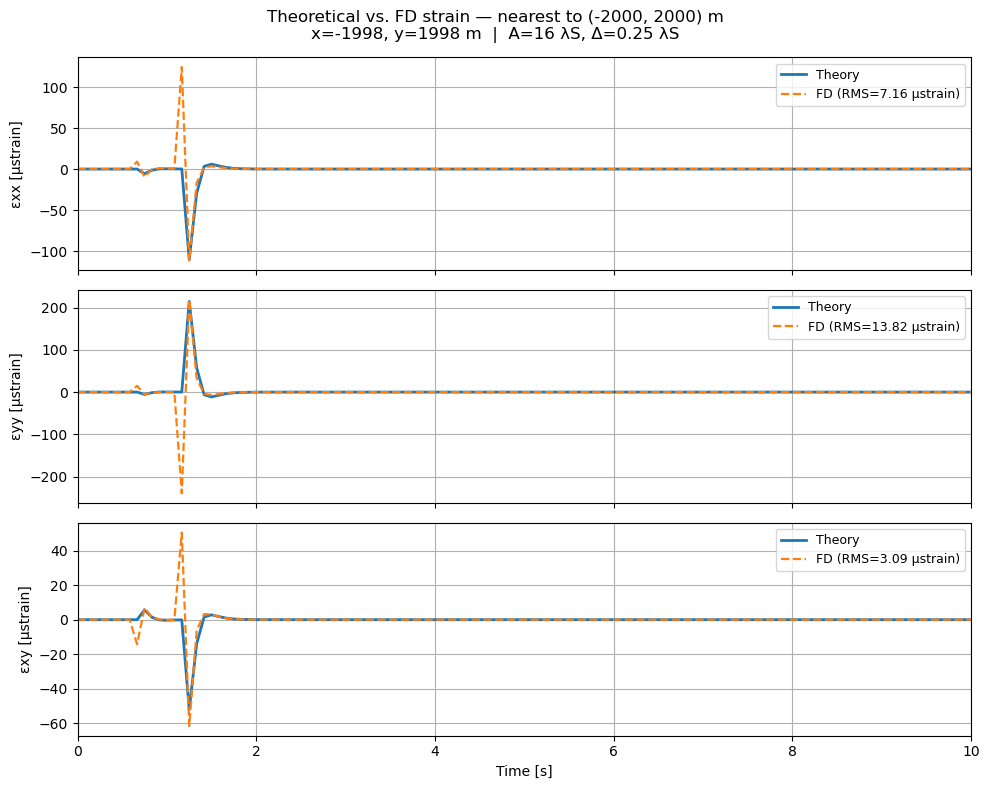

In [19]:
# --- Theoretical vs. FD strain at the station nearest to (xt, yt) [m] ---

A_sel, D_sel = 16, 0.25
xt, yt = -2000.0, 2000.0  # target coordinates to compare (meters)

# 1) Fetch grid and theoretical strains ('strains')
bundle = results_E[(A_sel, D_sel)]
xs, ys = bundle["grid"]
th = bundle["strains"]

# 2) FD strains: if missing, rebuild the same station keys and compute → store
if "strains_fd" not in bundle:
    stations_grid = {}
    k = 0
    for j, yv in enumerate(ys):
        for i, xv in enumerate(xs):
            k += 1
            stations_grid[f"G{A_sel}_{D_sel}_{k:04d}"] = {
                "position": [float(xv), float(yv), 0.0]
            }
    bundle["strains_fd"] = strain_fd(elastic, source_cfg, stations_grid, t, Mhat, mddot)

fd = bundle["strains_fd"]

# 3) Recover (x, y) from a key (no need to store stations_grid)
def pos_from_key(key: str) -> np.ndarray:
    k = int(key.rsplit("_", 1)[1]) - 1
    nx = len(xs)
    j, i = divmod(k, nx)
    return np.array([xs[i], ys[j], 0.0], dtype=float)

# 4) Choose the nearest *interior* FD key to (xt, yt)
target = np.array([xt, yt])
fd_keys = list(fd.keys())
xy_fd = np.array([pos_from_key(k)[:2] for k in fd_keys])  # (N, 2)
nearest_idx = np.argmin(np.linalg.norm(xy_fd - target, axis=1))
picked_key = fd_keys[nearest_idx]
picked_xy  = xy_fd[nearest_idx]

# 5) Plot (µstrain)
SCALE = 1e6
comps = [("εxx", (0, 0)), ("εyy", (1, 1)), ("εxy", (0, 1))]

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for ax, (lab, (ii, jj)) in zip(axes, comps):
    e_th = th[picked_key]["strain"][:, ii, jj] * SCALE
    e_fd = fd[picked_key]["strain"][:, ii, jj] * SCALE
    rms  = float(np.sqrt(np.mean((e_fd - e_th) ** 2)))
    ax.plot(t, e_th, lw=2.0, label="Theory")
    ax.plot(t, e_fd, lw=1.6, ls="--", label=f"FD (RMS={rms:.2f} µstrain)")
    ax.set_ylabel(f"{lab} [µstrain]")
    ax.set_xlim(0, 10)
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=9)

axes[-1].set_xlabel("Time [s]")
fig.suptitle(
    f"Theoretical vs. FD strain — nearest to ({xt:.0f}, {yt:.0f}) m\n"
    f"x={picked_xy[0]:.0f}, y={picked_xy[1]:.0f} m  |  "
    f"A={A_sel} λS, Δ={D_sel} λS",
    y=0.98
)
plt.tight_layout()
plt.show()


### MSE

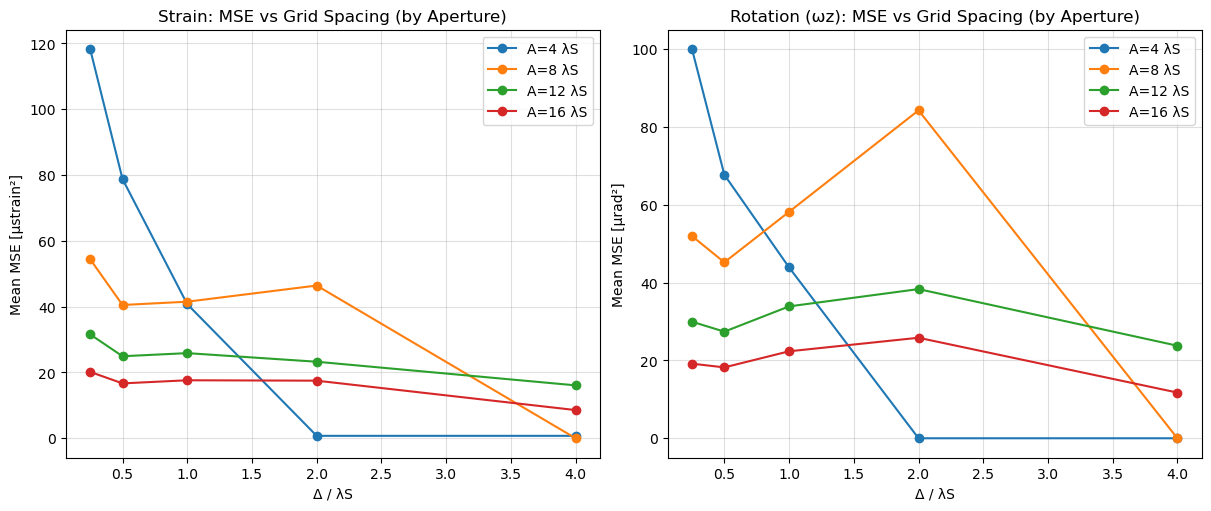

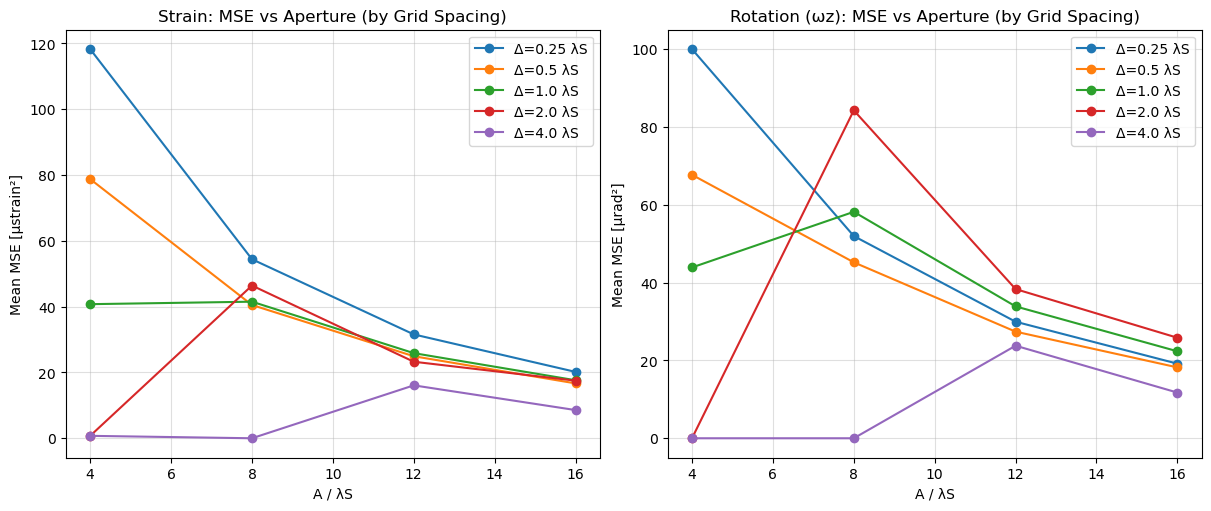

In [21]:
# === Mean MSE for strain (µstrain²) and rotation ωz (µrad²)
#     Curves vs Δ/λS (grouped by A) and vs A/λS (grouped by Δ) ===
# ---------- settings ----------
SCALE_STR = 1e6   # strain -> µstrain
SCALE_ROT = 1e6   # rad   -> µrad
YLOG_D    = False # set True to use log scale on Y (vs Δ)
YLOG_A    = False # set True to use log scale on Y (vs A)
# ---------- helpers ----------
def _rebuild_stations_grid(xs, ys, A, D):
    """Rebuild the station dict on the grid to match results_E naming."""
    stations_grid, k = {}, 0
    for j, yv in enumerate(ys):
        for i, xv in enumerate(xs):
            k += 1
            stations_grid[f"G{A}_{D}_{k:04d}"] = {"position": [float(xv), float(yv), 0.0]}
    return stations_grid

def ensure_fd_for_all_results():
    """If a bundle in results_E lacks 'strains_fd', compute and attach it."""
    for (A, D), bundle in results_E.items():
        if "strains_fd" in bundle:
            continue
        xs, ys = bundle["grid"]
        stations_grid = _rebuild_stations_grid(xs, ys, A, D)
        bundle["strains_fd"] = strain_fd(elastic, source_cfg, stations_grid, t, Mhat, mddot)

def _omega_z_from_entry(entry):
    """Return ωz(t) from entry, trying omega_vec -> rotation -> grad."""
    if "omega_vec" in entry and entry["omega_vec"] is not None:
        return np.asarray(entry["omega_vec"], float)[:, 2]
    if "rotation" in entry and entry["rotation"] is not None:
        rot = np.asarray(entry["rotation"], float)        # antisymmetric tensor Ω
        return rot[:, 0, 1]                               # Ω_xy = ωz
    if "grad" in entry and entry["grad"] is not None:
        G = np.asarray(entry["grad"], float)
        A = 0.5 * (G - np.transpose(G, (0, 2, 1)))        # antisymmetric
        return A[:, 0, 1]                                  # Ω_xy = ωz
    raise KeyError("Rotation ωz not found (need 'omega_vec' or 'rotation' or 'grad').")

# ---------- mean MSE (strain) ----------
def mean_mse_strain(cfg):
    """
    Mean MSE [µstrain²] using εxx, εyy, εxy at interior stations.
    """
    th = results_E[cfg]["strains"]
    fd = results_E[cfg]["strains_fd"]
    per_station = []
    for key in fd.keys():  # only interior stations included by FD
        mse_sum = 0.0
        for (ii, jj) in [(0, 0), (1, 1), (0, 1)]:  # xx, yy, xy
            diff = (fd[key]["strain"][:, ii, jj] - th[key]["strain"][:, ii, jj]) * SCALE_STR
            mse_sum += float(np.nanmean(diff * diff))
        per_station.append(mse_sum / 3.0)
    return float(np.nanmean(per_station)) if per_station else np.nan

# ---------- mean MSE (rotation ωz only) ----------
def mean_mse_rotation_oz(cfg):
    """
    Mean MSE [µrad²] for rotation (ωz only) at interior stations.
    """
    th = results_E[cfg]["strains"]      # theory dict with same keys/locations
    fd = results_E[cfg]["strains_fd"]
    per_station = []
    for key in fd.keys():  # interior only
        try:
            oz_th = _omega_z_from_entry(th[key]) * SCALE_ROT
            oz_fd = _omega_z_from_entry(fd[key]) * SCALE_ROT
        except KeyError:
            # skip this station if either side lacks rotation info
            continue
        diff = oz_fd - oz_th
        per_station.append(float(np.nanmean(diff * diff)))
    return float(np.nanmean(per_station)) if per_station else np.nan

# ---------- ensure FD exists ----------
ensure_fd_for_all_results()

A_list = sorted({a for a, _ in results_E.keys()})
D_list = sorted({d for _, d in results_E.keys()})

# ---------- Curves vs Δ/λS (grouped by aperture A) ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# strain
for A in A_list:
    xs_curve, ys_curve = [], []
    for D in D_list:
        cfg = (A, D)
        if cfg in results_E and "strains_fd" in results_E[cfg]:
            val = mean_mse_strain(cfg)
            if np.isfinite(val):
                xs_curve.append(D); ys_curve.append(val)
    if xs_curve:
        ax[0].plot(xs_curve, ys_curve, marker='o', label=f"A={A} λS")
ax[0].set_xlabel("Δ / λS"); ax[0].set_ylabel("Mean MSE [µstrain²]")
ax[0].set_title("Strain: MSE vs Grid Spacing (by Aperture)")
ax[0].grid(True, alpha=0.4); ax[0].legend()
if YLOG_D: ax[0].set_yscale("log")

# rotation ωz
for A in A_list:
    xs_curve, ys_curve = [], []
    for D in D_list:
        cfg = (A, D)
        if cfg in results_E and "strains_fd" in results_E[cfg]:
            val = mean_mse_rotation_oz(cfg)
            if np.isfinite(val):
                xs_curve.append(D); ys_curve.append(val)
    if xs_curve:
        ax[1].plot(xs_curve, ys_curve, marker='o', label=f"A={A} λS")
ax[1].set_xlabel("Δ / λS"); ax[1].set_ylabel("Mean MSE [µrad²]")
ax[1].set_title("Rotation (ωz): MSE vs Grid Spacing (by Aperture)")
ax[1].grid(True, alpha=0.4); ax[1].legend()
if YLOG_D: ax[1].set_yscale("log")

plt.show()

# ---------- Curves vs A/λS (grouped by grid spacing Δ) ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# strain
for D in D_list:
    xs_curve, ys_curve = [], []
    for A in A_list:
        cfg = (A, D)
        if cfg in results_E and "strains_fd" in results_E[cfg]:
            val = mean_mse_strain(cfg)
            if np.isfinite(val):
                xs_curve.append(A); ys_curve.append(val)
    if xs_curve:
        ax[0].plot(xs_curve, ys_curve, marker='o', label=f"Δ={D} λS")
ax[0].set_xlabel("A / λS"); ax[0].set_ylabel("Mean MSE [µstrain²]")
ax[0].set_title("Strain: MSE vs Aperture (by Grid Spacing)")
ax[0].grid(True, alpha=0.4); ax[0].legend()
if YLOG_A: ax[0].set_yscale("log")

# rotation ωz
for D in D_list:
    xs_curve, ys_curve = [], []
    for A in A_list:
        cfg = (A, D)
        if cfg in results_E and "strains_fd" in results_E[cfg]:
            val = mean_mse_rotation_oz(cfg)
            if np.isfinite(val):
                xs_curve.append(A); ys_curve.append(val)
    if xs_curve:
        ax[1].plot(xs_curve, ys_curve, marker='o', label=f"Δ={D} λS")
ax[1].set_xlabel("A / λS"); ax[1].set_ylabel("Mean MSE [µrad²]")
ax[1].set_title("Rotation (ωz): MSE vs Aperture (by Grid Spacing)")
ax[1].grid(True, alpha=0.4); ax[1].legend()
if YLOG_A: ax[1].set_yscale("log")

plt.show()


### Radiation pattern

/var/folders/2y/wy3tvs7d0z15dfkn4ybxqnpr0000gp/T/ipykernel_85351/1841210261.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_div = cm.get_cmap("coolwarm").copy(); cmap_div.set_bad("white")
/var/folders/2y/wy3tvs7d0z15dfkn4ybxqnpr0000gp/T/ipykernel_85351/1841210261.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_seq = cm.get_cmap("turbo").copy();    cmap_seq.set_bad("white")


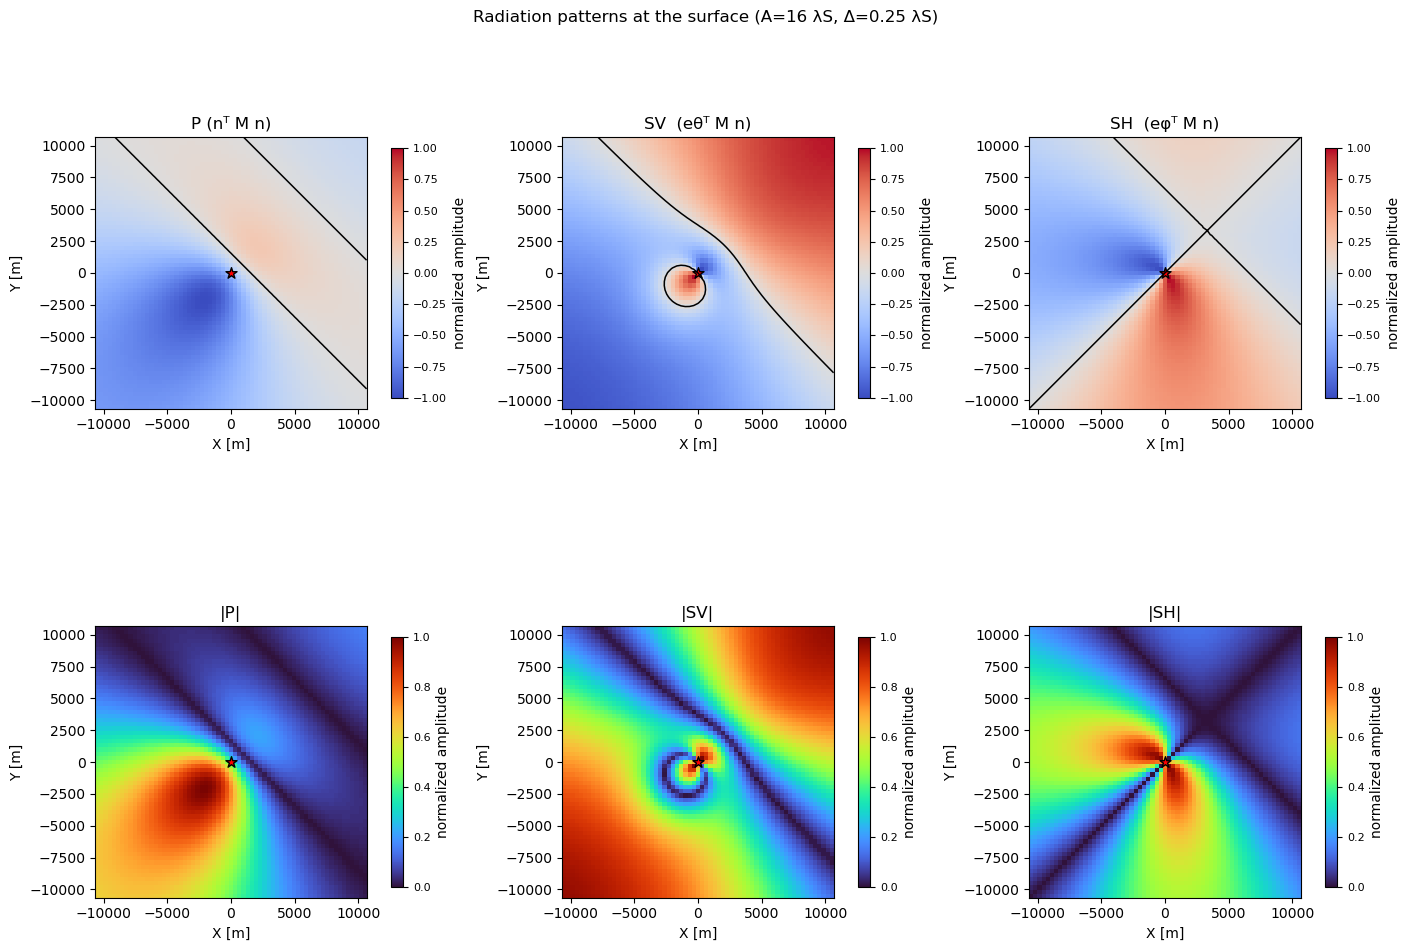

In [23]:
# === Full radiation maps on the surface: P / SV / SH (signed & absolute) ===
# Requirements in session:
#   xs, ys                      : 1D arrays (surface grid coordinates, z=0)
#   source_cfg["location"]      : (x_s, y_s, z_s)
#   either M (3x3) or Mhat (3x3): normalized moment tensor (DC or general)
# Optional:
#   source_cfg["mechanism"] with keys strike/dip/rake (floats)
#   A_sel/D_sel or A_pick/D_pick (for title only)

# --- Assertions / fallbacks ---
assert 'xs' in locals() and 'ys' in locals(), "xs, ys are required."
assert 'source_cfg' in locals() and 'location' in source_cfg, "source_cfg['location'] is required."

if 'M' in locals():
    M_use = np.array(M, float)
elif 'Mhat' in locals():
    M_use = np.array(Mhat, float)
else:
    raise AssertionError("Provide M (3x3) or Mhat (3x3).")

src = np.array(source_cfg["location"], float)  # (x_s, y_s, z_s)
I   = np.eye(3)

# --- Build grid & observation directions n ---
X, Y = np.meshgrid(xs, ys)
Zobs = np.zeros_like(X)
rvec = np.stack([X - src[0], Y - src[1], Zobs - src[2]], axis=-1)  # (...,3)
r    = np.linalg.norm(rvec, axis=-1)
eps  = 1e-9
n    = rvec / np.maximum(r, eps)[..., None]  # unit direction from source to surface point

# --- Radiation kernels ---
# P (signed): nᵀ M n
Psgn = np.einsum("...i,ij,...j->...", n, M_use, n)
Pabs = np.abs(Psgn)

# S vector in plane orthogonal to n: (I - n nᵀ) (M n)
Mn   = np.einsum("ij,...j->...i", M_use, n)
proj = I - np.einsum("...i,...j->...ij", n, n)
Svec = np.einsum("...ij,...j->...i", proj, Mn)

# SV / SH basis at the surface
khat = np.array([0.0, 0.0, 1.0])          # vertical up
eSH  = np.cross(khat, n)                  # azimuthal (tangential)
eSH /= np.maximum(np.linalg.norm(eSH, axis=-1, keepdims=True), 1e-9)
eSV  = np.cross(eSH, n)                   # radial (in the ray plane)
eSV /= np.maximum(np.linalg.norm(eSV, axis=-1, keepdims=True), 1e-9)

# --- Signed SV/SH radiation coefficients (keep amplitudes too) ---
RSH_sgn = np.einsum("...i,...i->...", Svec, eSH)  # = eφᵀ M n (signed)
RSV_sgn = np.einsum("...i,...i->...", Svec, eSV)  # = eθᵀ M n (signed)
Ash     = np.abs(RSH_sgn)
Asv     = np.abs(RSV_sgn)

# --- Mask near-source singularity (tune threshold if needed) ---
mask = (r < 1.0)
for Z in (Psgn, Pabs, RSH_sgn, RSV_sgn, Ash, Asv):
    Z[mask] = np.nan

# --- Robust normalizers ---
def _norm_signed(Z):
    m = np.nanmax(np.abs(Z))
    return Z / (m if m and np.isfinite(m) else 1.0)

def _norm_abs(Z):
    m = np.nanmax(np.abs(Z))
    return np.abs(Z) / (m if m and np.isfinite(m) else 1.0)

Psgn_plot = _norm_signed(Psgn)
RSV_plot  = _norm_signed(RSV_sgn)
RSH_plot  = _norm_signed(RSH_sgn)
Pabs_plot = _norm_abs(Pabs)
Asv_plot  = _norm_abs(Asv)
Ash_plot  = _norm_abs(Ash)

# --- Plotting: 2×3 panels (signed on top row, absolute on bottom row) ---
fig, axes = plt.subplots(2, 3, figsize=(14, 10), constrained_layout=True)
panels = [
    ("P (nᵀ M n)",    Psgn_plot, "diverging"),
    ("SV  (eθᵀ M n)",   RSV_plot,  "diverging"),
    ("SH  (eφᵀ M n)",   RSH_plot,  "diverging"),
    ("|P|",                   Pabs_plot, "sequential"),
    ("|SV|",                  Asv_plot,  "sequential"),
    ("|SH|",                  Ash_plot,  "sequential"),
]

# Colormaps with NaNs shown as white
cmap_div = cm.get_cmap("coolwarm").copy(); cmap_div.set_bad("white")
cmap_seq = cm.get_cmap("turbo").copy();    cmap_seq.set_bad("white")

for ax, (title, Z, kind) in zip(axes.ravel(), panels):
    im = ax.imshow(
        Z, origin="lower",
        extent=[xs[0], xs[-1], ys[0], ys[-1]],
        aspect="equal",
        cmap=(cmap_div if kind=="diverging" else cmap_seq),
        vmin=(-1.0 if kind=="diverging" else 0.0),
        vmax=+1.0
    )
    # Source marker
    ax.scatter(src[0], src[1], c="r", marker="*", s=70, edgecolors="k")
    ax.set_title(title)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=8)
    cb.set_label("normalized amplitude")

# Nodal lines (R = 0) on the signed row
axes[0, 0].contour(X, Y, Psgn,     levels=[0.0], colors="k", linewidths=1.1)
axes[0, 1].contour(X, Y, RSV_sgn,  levels=[0.0], colors="k", linewidths=1.1)
axes[0, 2].contour(X, Y, RSH_sgn,  levels=[0.0], colors="k", linewidths=1.1)
# --- Title with available (A, Δ) selection info ---
if   'A_sel' in locals() and 'D_sel' in locals():  A_show, D_show = A_sel, D_sel
elif 'A_pick' in locals() and 'D_pick' in locals(): A_show, D_show = A_pick, D_pick
else: A_show, D_show = '—', '—'

fig.suptitle(f"Radiation patterns at the surface (A={A_show} λS, Δ={D_show} λS)", fontsize=12)
plt.show()
